# Transformers + Training Method Benchmark

<img src="./../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid green; padding: 10px;">
In this notebook we will compare the performances of the different models that we have fine-tuned
</div>

# Evaluation Metrics: F1-Score, Recall, and Precision

In this document, we explore three critical metrics commonly used in classification tasks: F1-score, recall, and precision. These metrics are essential for evaluating the performance of a model, especially in scenarios where class imbalance might affect the model's accuracy. We will also discuss the different versions of these metrics: macro, micro, and weighted, to provide a comprehensive understanding of how they can be applied to various datasets.

## 1. Precision

Precision measures the accuracy of positive predictions. Formally, it is defined as the ratio of true positives to the sum of true and false positives.

$$ \text{Precision} = \frac{TP}{TP + FP} $$

- **TP**: True Positives
- **FP**: False Positives

## 2. Recall

Recall, also known as sensitivity, measures the ability of a model to find all the relevant cases (true positives) within a dataset.

$$ \text{Recall} = \frac{TP}{TP + FN} $$

- **TP**: True Positives
- **FN**: False Negatives

## 3. F1-Score

The F1-score is the harmonic mean of precision and recall. It is a way to combine both precision and recall into a single measure that captures both properties.

$$ \text{F1-Score} = 2 \cdot \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

## Versions of Metrics

These metrics can be calculated in three different ways to accommodate the variability in class distribution:

### a. Macro

The macro method calculates the metric independently for each class and then takes the average. This method treats all classes equally, regardless of their frequency.

### b. Micro

The micro method aggregates the contributions of all classes to compute the average metric. In this approach, the metrics are computed globally by counting the total true positives, false negatives, and false positives.

### c. Weighted

The weighted method calculates metrics for each class independently but uses a weight that reflects the prevalence of each class. This approach helps to address class imbalance by considering the relative size of each class.

By focusing on these metrics and their variants, we can better understand and improve the performance of classification models across different scenarios and datasets.


In [50]:
# Transformers setup
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer
)
from datasets import load_dataset

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Data processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Internal imports for evaluation
from text_multi_classification import TextMultiClassificationEvaluator

In [51]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
tokenizer = AutoTokenizer.from_pretrained("../training/transformers/base/gte-base-lazy-teacher")

model_os = AutoModelForSequenceClassification.from_pretrained("../training/transformers/oversampled/gte-base-lazy-teacher-os",
                                                              trust_remote_code=True).to("mps")
model_base = AutoModelForSequenceClassification.from_pretrained("../training/transformers/base/gte-base-lazy-teacher",
                                                                trust_remote_code=True).to("mps")
model_w = AutoModelForSequenceClassification.from_pretrained("../training/transformers/weighted/gte-base-lazy-teacher-weighted",
                                                             trust_remote_code=True).to("mps")

In [53]:
data_test = load_dataset('csv', data_files='../../data/test.csv', split='train')

In [54]:
data_test = data_test.map(
    lambda x:
    {
        "labels": x["labels"] - 1,
    }
)

In [55]:
data_test

Dataset({
    features: ['corrected_text', 'length', 'ratio_err', 'labels'],
    num_rows: 3462
})

In [56]:
label_mappping = {f"LABEL_{i}": i for i in range(6)}
print(label_mappping)

{'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2, 'LABEL_3': 3, 'LABEL_4': 4, 'LABEL_5': 5}


In [57]:
task_evaluator = TextMultiClassificationEvaluator(default_metric_name="accuracy")

In [58]:
metrics_kwargs = {
    "f1": [{"average": "macro"}, {"average": "weighted"}, {"average": "micro"}],
    "precision": [{"average": "macro"}, {"average": "weighted"}, {"average": "micro"}],
    "recall": [{"average": "macro"}, {"average": "weighted"}, {"average": "micro"}],
    "accuracy": {},
    "confusion_matrix": {}
}

In [ ]:
res_base = task_evaluator.compute(
    model_or_pipeline=model_base,
    tokenizer=tokenizer,
    device="mps",
    data=data_test,
    metric=["f1", "accuracy", "precision", "recall", "confusion_matrix"],
    label_mapping=label_mappping,
    input_column="corrected_text",
    label_column="labels",
    random_state=42,
    metrics_kwargs=metrics_kwargs
)

In [ ]:
res_os = task_evaluator.compute(
    model_or_pipeline=model_os,
    tokenizer=tokenizer,
    device="mps",
    data=data_test,
    metric=["f1", "accuracy", "precision", "recall", "confusion_matrix"],
    label_mapping=label_mappping,
    input_column="corrected_text",
    label_column="labels",
    random_state=42,
    metrics_kwargs=metrics_kwargs
)

In [ ]:
res_w = task_evaluator.compute(
    model_or_pipeline=model_w,
    tokenizer=tokenizer,
    device="mps",
    data=data_test,
    metric=["f1", "accuracy", "precision", "recall", "confusion_matrix"],
    label_mapping=label_mappping,
    input_column="corrected_text",
    label_column="labels",
    random_state=42,
    metrics_kwargs=metrics_kwargs
)

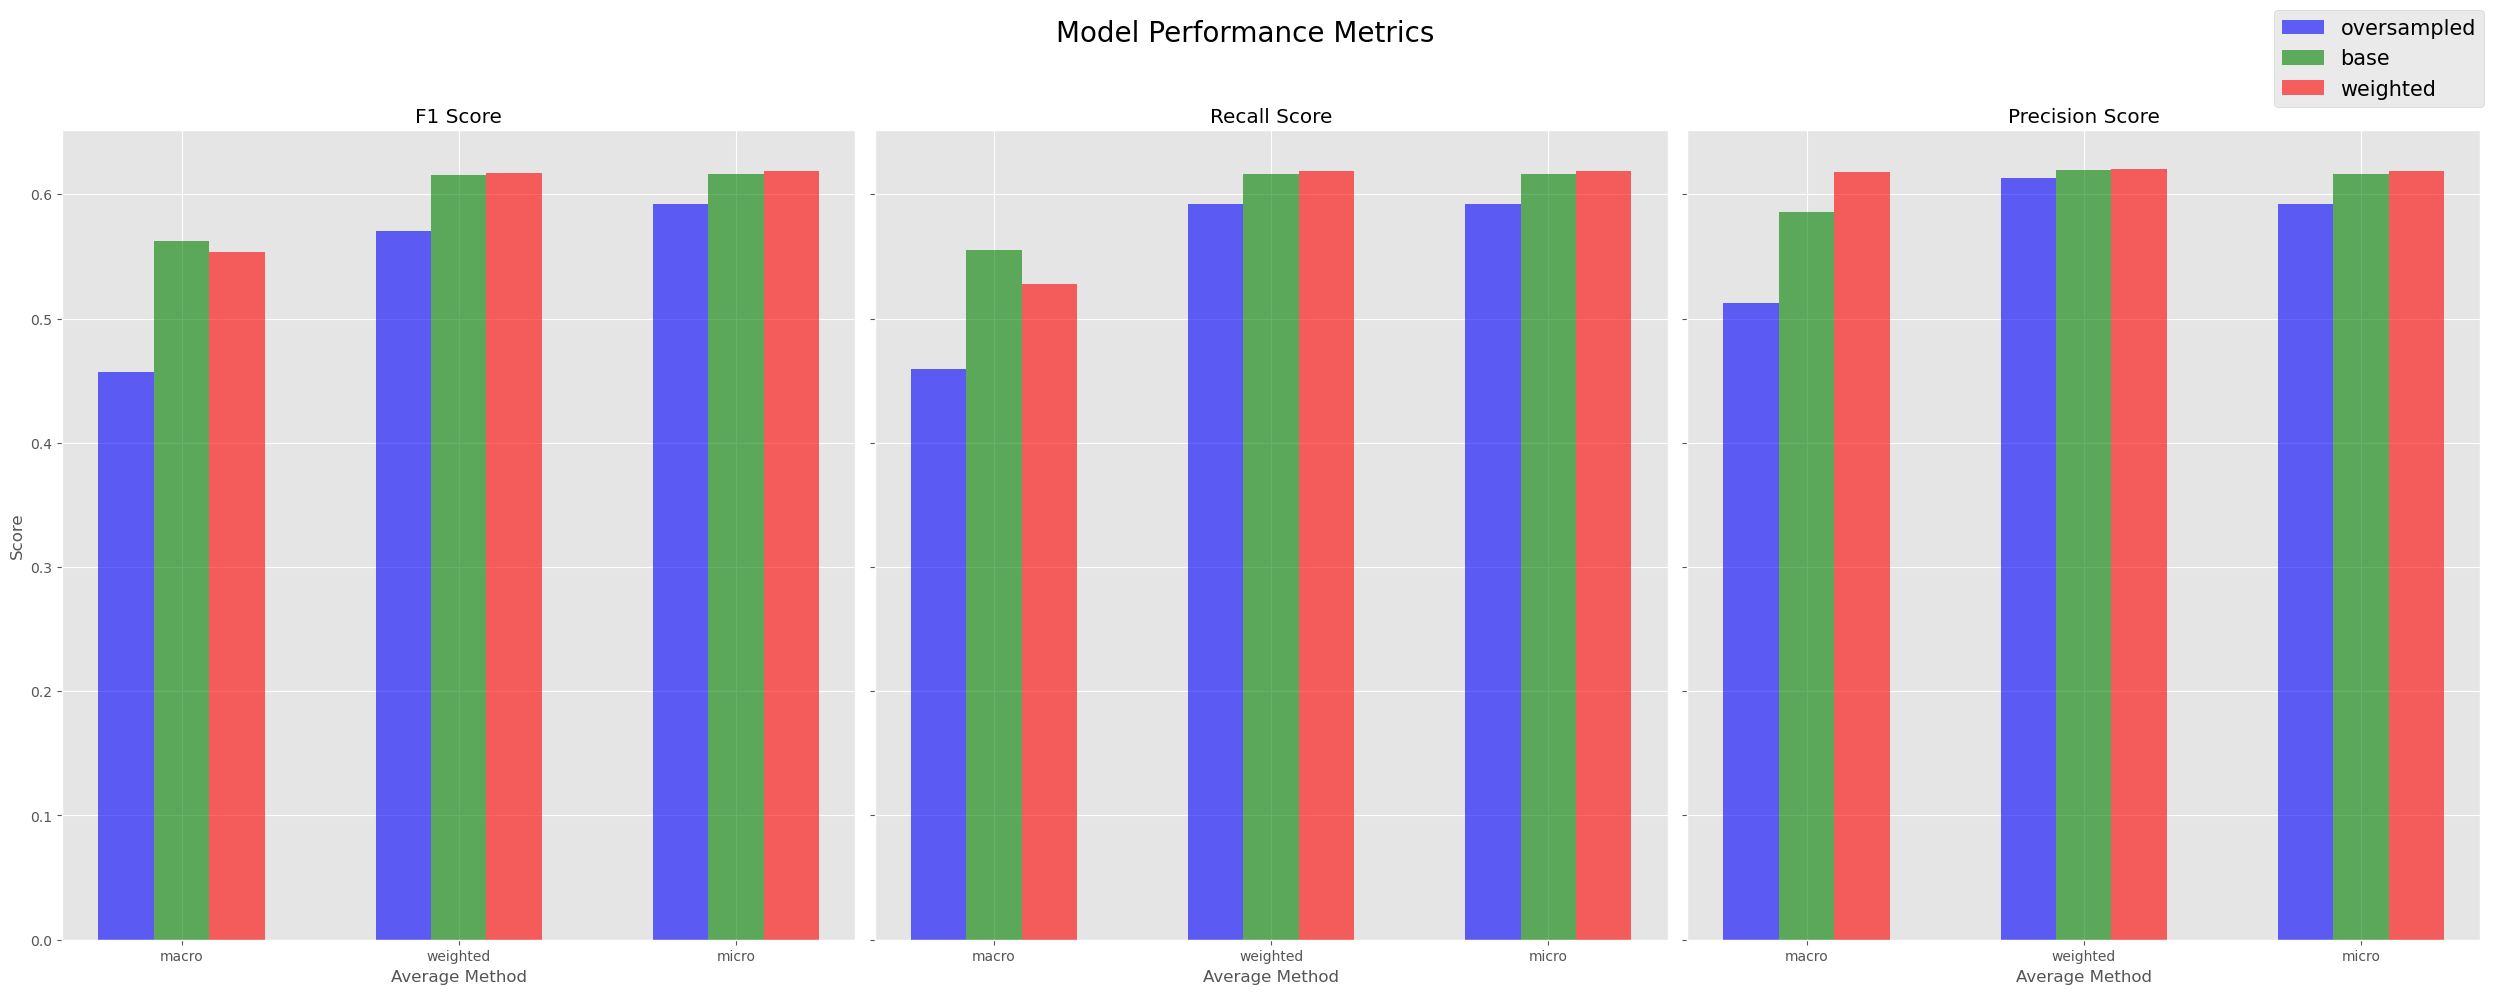

In [67]:
df_os = pd.DataFrame(res_os)
df_base = pd.DataFrame(res_base)
df_w = pd.DataFrame(res_w)

df_os['model'] = 'oversampled'
df_base['model'] = 'base'
df_w['model'] = 'weighted'

df = pd.concat([df_os, df_base, df_w])

metrics = ['f1_macro', 'f1_weighted', 'f1_micro', 'precision_macro', 'precision_weighted', 'precision_micro', 'recall_macro', 'recall_weighted', 'recall_micro']
df_metrics = df[['model'] + metrics]

df_melted = df_metrics.melt(id_vars='model', var_name='metric', value_name='value')

df_melted[['metric_type', 'average_method']] = df_melted['metric'].str.split('_', expand=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10), sharey=True)
fig.suptitle('Model Performance Metrics', fontsize=20)

colors = {'oversampled': 'blue', 'base': 'green', 'weighted': 'red'}

bar_width = 0.2
bar_positions = np.arange(len(df_melted['average_method'].unique()))

def create_bars(ax, df, metric_type, title):
    for i, model in enumerate(df['model'].unique()):
        subset = df[(df['metric_type'] == metric_type) & (df['model'] == model)]
        ax.bar(bar_positions + i * bar_width, subset['value'], width=bar_width, label=model, color=colors[model], alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Average Method')
    ax.set_xticks(bar_positions + bar_width)
    ax.set_xticklabels(subset['average_method'].unique())

create_bars(axes[0], df_melted, 'f1', 'F1 Score')
axes[0].set_ylabel('Score')

create_bars(axes[1], df_melted, 'recall', 'Recall Score')

create_bars(axes[2], df_melted, 'precision', 'Precision Score')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=15)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

<img src="./../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">
Oversampling seems to add too much bias, and the best performing model seems to be the one that was trained with weights for each class.
</div>

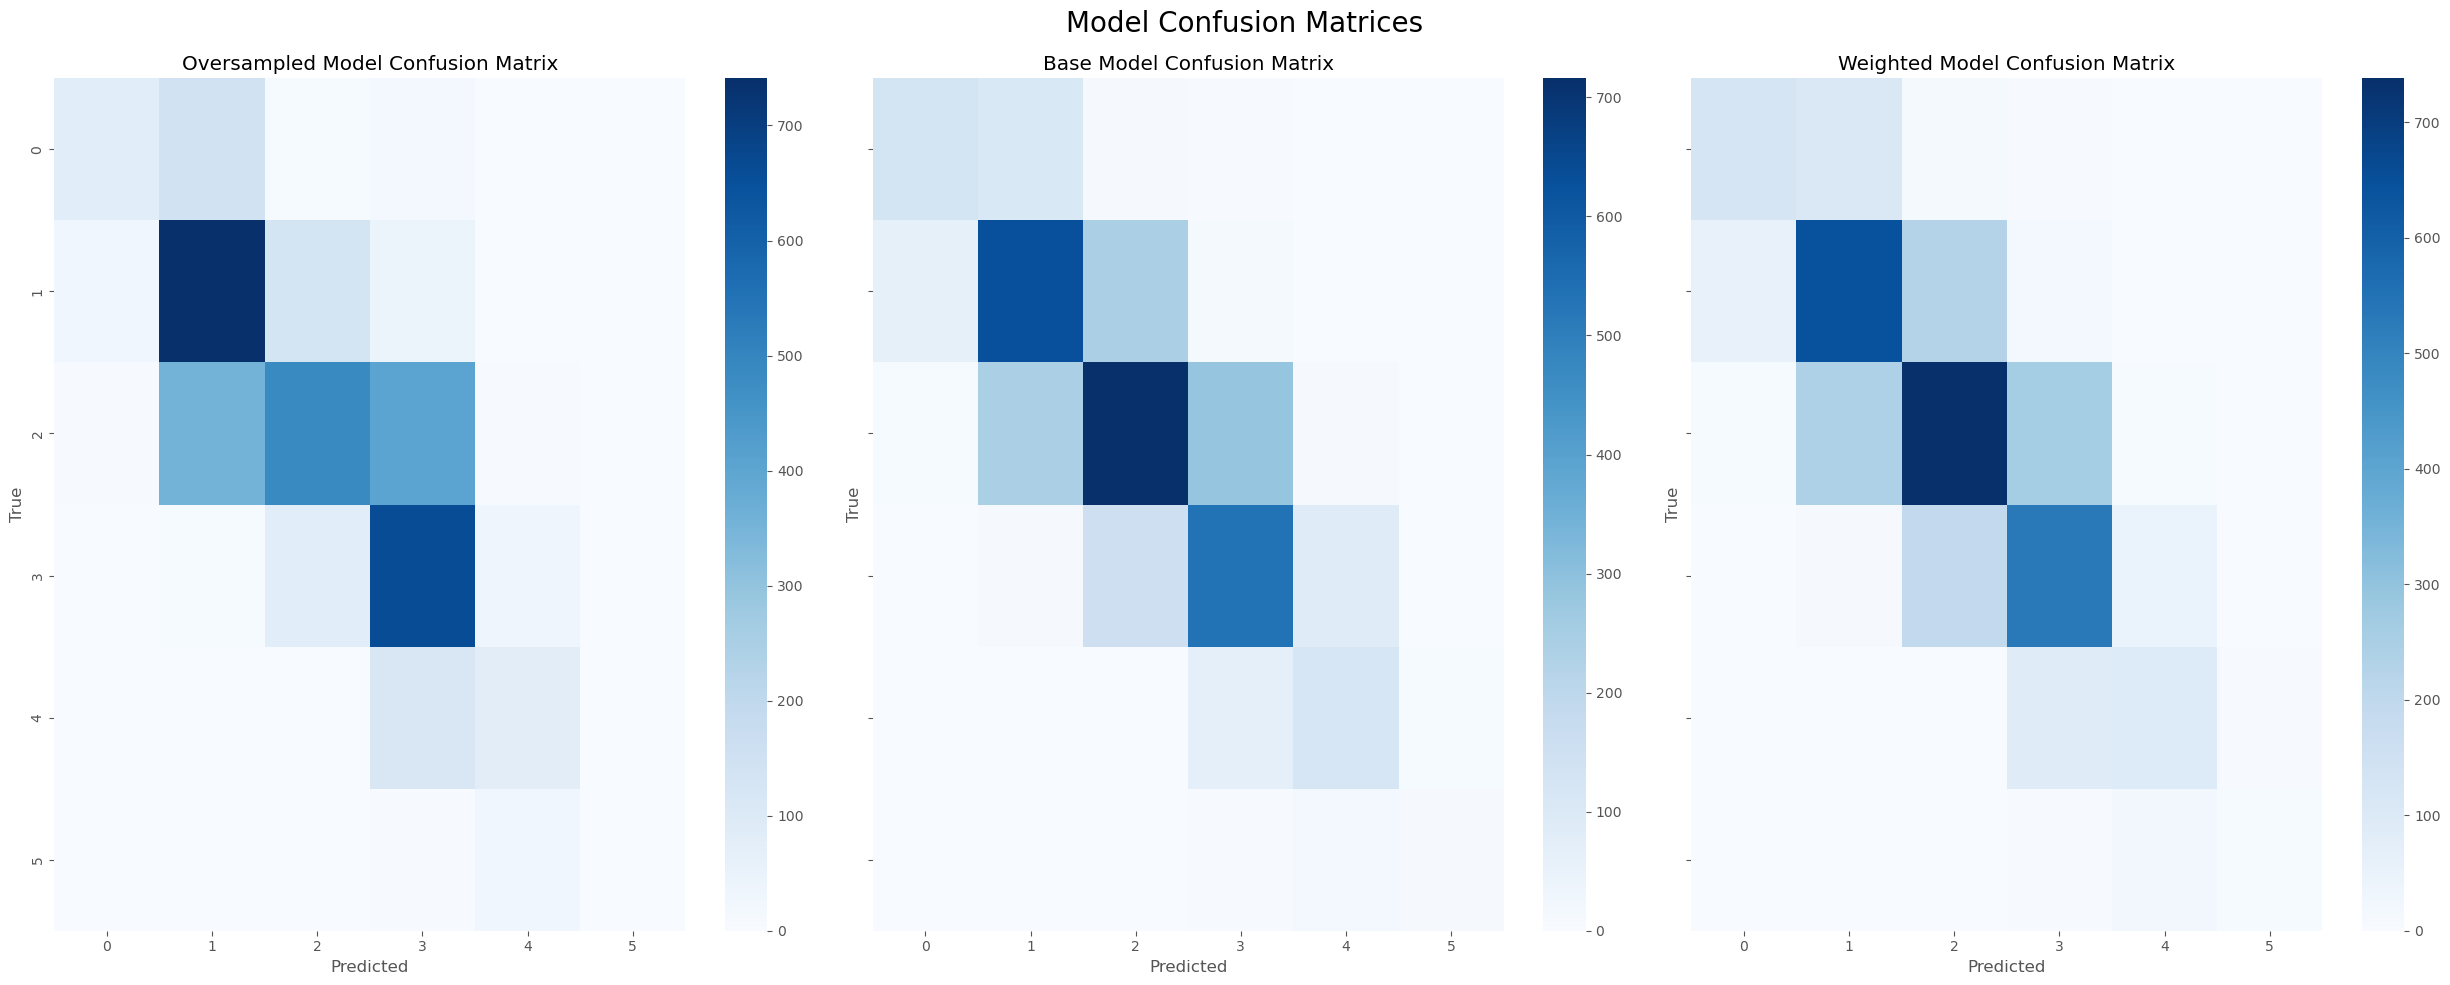

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10), sharey=True)

for i, model in enumerate(df['model'].unique()):
    subset = df[df['model'] == model]
    sns.heatmap(subset['confusion_matrix_'][0], ax=axes[i], annot=False, fmt='d', cmap='Blues')
    axes[i].set_title(f'{model.capitalize()} Model Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Model Confusion Matrices', fontsize=20)
plt.show()

<img src="./../rsrc/idea.png" alt="Explanation Image" width="50" height="50">

<div style="border: 2px solid red; padding: 10px;">
In fact, the oversample model does not seem to perform well and predicts majority classes even less well without predicting minority classes well
</div>

## Conclusion

<img src="./../rsrc/insights.png" alt="Explanation Image" width="250" height="250">

<div style="border: 2px solid green; padding: 10px;">
In this notebook we were able to compare and decide on the final model. We will still analyze the errors in this model in more detail to try to recover certain information.
</div>